## Modeling for predicting critical outcome at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [12]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/home/logasan/mimic4ed-benchmark/Benchmark_scripts/processed/'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95

In [13]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0


In [14]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [15]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [16]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [17]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [18]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [19]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [20]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.07053365376014503 : 1


### 3.  Modeling script

In [21]:
# Containers for all results
result_list = []

In [22]:
# Hyperparameter tuning for Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
para_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [100,10,1,0.1,0.01],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
]

clf = GridSearchCV(logreg,param_grid=para_grid,cv=3,verbose=1,n_jobs=-1)
best_clf = clf.fit(X_train,y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib

LogisticRegression(C=0.01, max_iter=10000, solver='saga')

Logistic Regression:
Training time: 92.2561731338501 seconds
AUC: 0.852499071668496
AUPRC: 0.3208641601868679
Sensitivity: 0.8022941970310391
Specificity: 0.7440476190476191
Score thresold: 0.4616244572013169
2.5 97.5


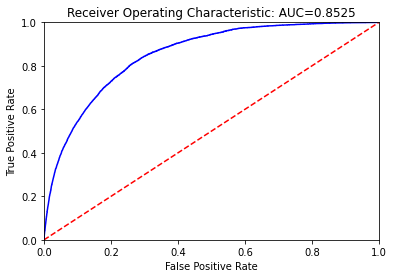

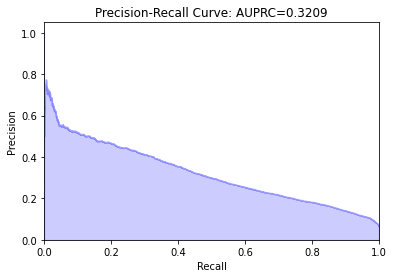

In [23]:
print("Logistic Regression:")
logreg=LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000, solver='saga')
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 359.5177164077759 seconds
AUC: 0.884605746943086
AUPRC: 0.402372998650525
Sensitivity: 0.8176450742240216
Specificity: 0.794231319782422
Score thresold: 0.08960987888058948
2.5 97.5


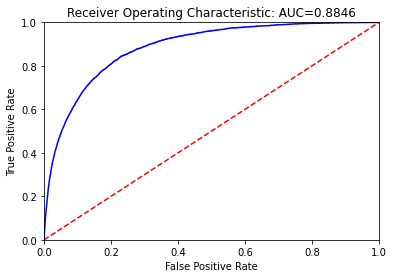

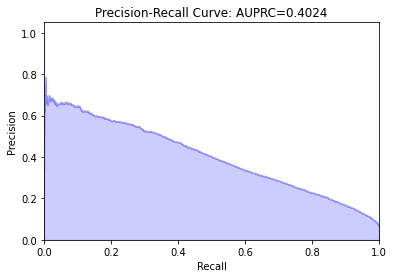

In [24]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [25]:
# Hyperparameter tuning for RandomForest
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_jobs=-1)
para_grid = [
    {'max_features' : ['auto','sqrt','log2'],
    'n_estimators' : [100,200,400,600,800,1000,1200,1400,1600,1800,2000],
    'max_depth' : [10,20,30,40,50,60,70,80,90,100]
    }
]

clf = RandomizedSearchCV(estimator=rf,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=100, max_features=log2, n_estimators=2000; total time= 1.1min
[CV] END max_depth=100, max_features=log2, n_estimators=2000; total time= 1.1min
[CV] END max_depth=100, max_features=log2, n_estimators=2000; total time= 1.1min
[CV] END .max_depth=10, max_features=log2, n_estimators=2000; total time=  34.0s
[CV] END .max_depth=10, max_features=log2, n_estimators=2000; total time=  33.8s
[CV] END .max_depth=10, max_features=log2, n_estimators=2000; total time=  33.9s
[CV] END ..max_depth=70, max_features=log2, n_estimators=200; total time=   7.7s
[CV] END ..max_depth=70, max_features=log2, n_estimators=200; total time=   7.7s
[CV] END ..max_depth=70, max_features=log2, n_estimators=200; total time=   7.7s
[CV] END .max_depth=90, max_features=auto, n_estimators=1800; total time= 1.2min
[CV] END .max_depth=90, max_features=auto, n_estimators=1800; total time= 1.2min
[CV] END .max_depth=90, max_features=auto, n_est

{'n_estimators': 1600, 'max_features': 'sqrt', 'max_depth': 30}

RandomForest:
Training time: 750.1988615989685 seconds
AUC: 0.8867523108117784
AUPRC: 0.38021614668201986
Sensitivity: 0.8275978407557355
Specificity: 0.7972492604256132
Score thresold: 0.11081887730093395
2.5 97.5


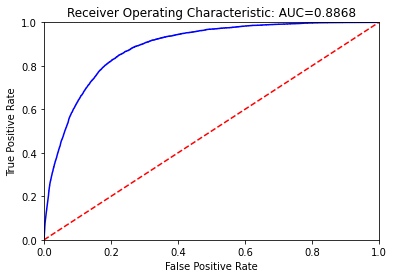

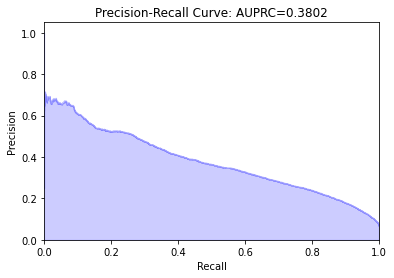

[0.09031593 0.00989995 0.00561692 0.00922772 0.01814686 0.0046902
 0.00780518 0.01376356 0.0024888  0.00684673 0.01384207 0.05434464
 0.08343146 0.04693828 0.07156928 0.07603434 0.06735937 0.05916452
 0.19994759 0.00816376 0.00532095 0.00344749 0.00068735 0.00269229
 0.00195707 0.0022245  0.00316116 0.00288793 0.00306614 0.0033631
 0.00609237 0.00345678 0.00324959 0.00164344 0.00489195 0.00179495
 0.00166113 0.00339336 0.00552926 0.00352045 0.00138291 0.00437889
 0.00421701 0.0021079  0.00291881 0.00070734 0.00608776 0.00323909
 0.00302714 0.00454597 0.00649902 0.00380102 0.0037752  0.00122949
 0.00450845 0.0039157  0.00311682 0.0081681  0.00144066 0.00293258
 0.00362863 0.00315543 0.00218908 0.00538858]


In [26]:
print("RandomForest:")
rf= RandomForestClassifier(class_weight='balanced', n_estimators=1600, max_features='sqrt', max_depth=30)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [27]:
# Hyperparameter tuning for Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
para_grid = [
    {'learning_rate' : [0.01,0.1,1,10,100],
    'n_estimators' : [5,50,250,500],
    'max_depth' : [1,3,5,7,9],
    }
]

clf = RandomizedSearchCV(estimator=gb,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 3.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 3.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=250; total time= 3.9min
[CV] END ....learning_rate=10, max_depth=9, n_estimators=250; total time= 5.3min
[CV] END ....learning_rate=10, max_depth=9, n_estimators=250; total time= 5.3min
[CV] END ....learning_rate=10, max_depth=9, n_estimators=250; total time= 5.3min
[CV] END .......learning_rate=1, max_depth=9, n_estimators=5; total time=   7.1s
[CV] END .......learning_rate=1, max_depth=9, n_estimators=5; total time=   7.2s
[CV] END .......learning_rate=1, max_depth=9, n_estimators=5; total time=   7.1s
[CV] END .....learning_rate=10, max_depth=7, n_estimators=50; total time=  49.8s
[CV] END .....learning_rate=10, max_depth=7, n_estimators=50; total time=  47.5s
[CV] END .....learning_rate=10, max_depth=7, n_e

{'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.01}

GradientBoosting:
Training time: 518.0261571407318 seconds
AUC: 0.8955418508439024
AUPRC: 0.4410185766913702
Sensitivity: 0.8085357624831309
Specificity: 0.8246492985971944
Score thresold: 0.08026998247460192
2.5 97.5


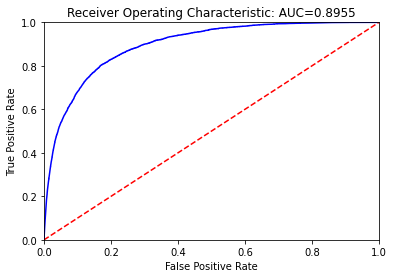

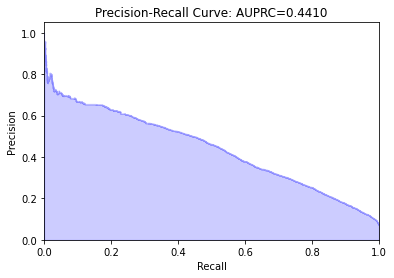

In [28]:
print("GradientBoosting:")
gb = GradientBoostingClassifier(n_estimators=250,max_depth=9,learning_rate=0.01)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [29]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [30]:
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.789784020478139
AUPRC: 0.1944936375006208
Sensitivity: 0.8959176788124157
Specificity: 0.6333142475427045
Score thresold: -2.6248987751080204
49.525 50.475


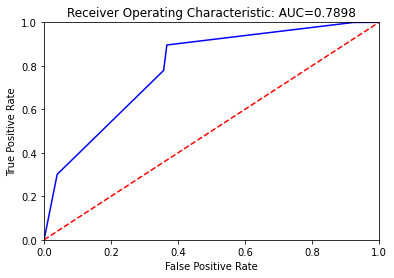

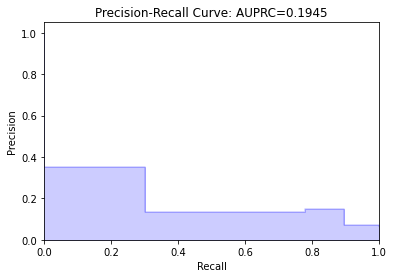

In [31]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI")

score_NEWS
AUC: 0.6002591746052351
AUPRC: 0.1525796637565012
Sensitivity: 0.4144736842105263
Specificity: 0.7993129115373605
Score thresold: 2
49.525 50.475


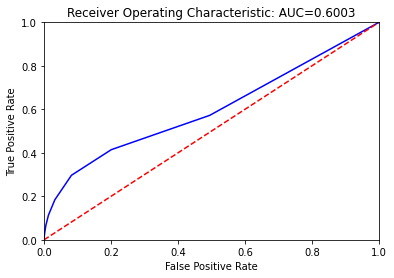

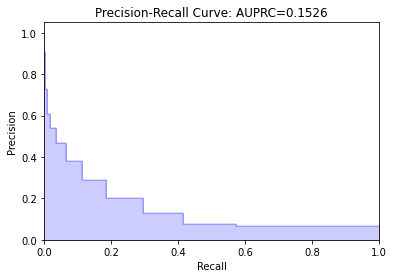

In [32]:
get_score_performance("score_NEWS")

score_NEWS2
AUC: 0.587080282037631
AUPRC: 0.13968412809478523
Sensitivity: 0.37449392712550605
Specificity: 0.8263789483729364
Score thresold: 2
49.525 50.475


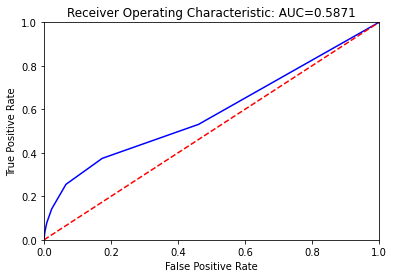

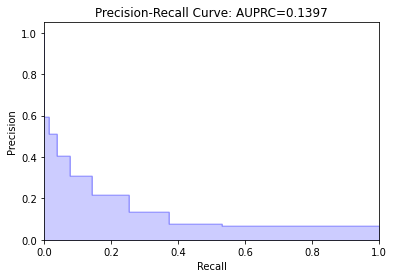

In [33]:
get_score_performance("score_NEWS2")

score_REMS
AUC: 0.6638998005167845
AUPRC: 0.11202249052255793
Sensitivity: 0.645748987854251
Specificity: 0.6163517511212901
Score thresold: 5
49.525 50.475


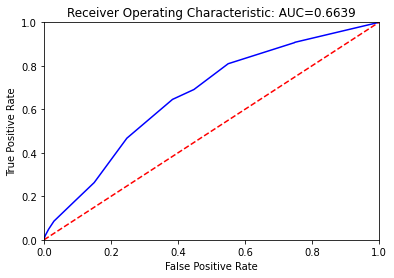

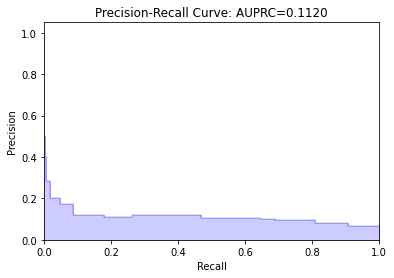

In [34]:
get_score_performance("score_REMS")

score_MEWS
AUC: 0.6056137210559542
AUPRC: 0.11437508107058239
Sensitivity: 0.40468960863697706
Specificity: 0.7761356045424181
Score thresold: 2
49.525 50.475


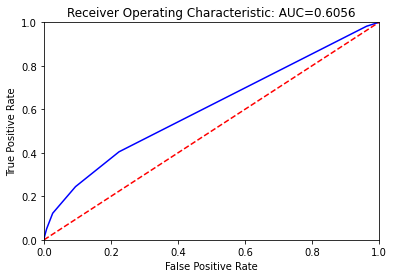

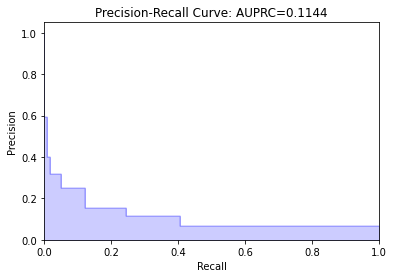

In [35]:
get_score_performance("score_MEWS")

score_CART
AUC: 0.6923679410907155
AUPRC: 0.15759081132763783
Sensitivity: 0.5588731443994602
Specificity: 0.7325603588128637
Score thresold: 6
49.525 50.475


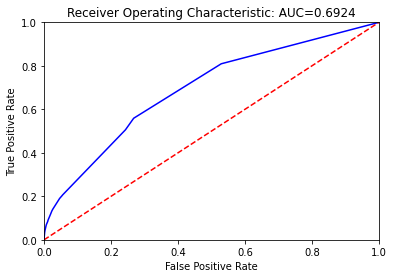

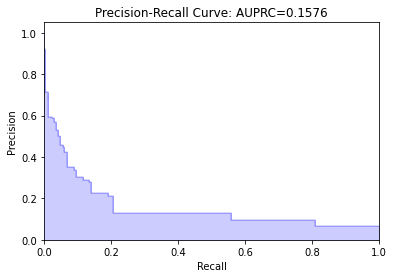

In [36]:
get_score_performance("score_CART")

### 4. Performance output

In [37]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.852499,0.320864,0.802294,0.744048,0.461624,0.847849,0.856444,0.002255,0.307727,0.334331,0.006485,0.787058,0.812928,0.006627,0.736208,0.755368,0.004841,92.256173
1,MLP,0.884606,0.402373,0.817645,0.794231,0.089610,0.880801,0.888642,0.002028,0.390259,0.417560,0.006864,0.803365,0.840800,0.007970,0.773712,0.807376,0.006465,359.517716
2,RF,0.886752,0.380216,0.827598,0.797249,0.110819,0.883174,0.890148,0.001824,0.368395,0.394710,0.006772,0.808468,0.837173,0.007758,0.792683,0.815687,0.006800,750.198862
3,GB,0.895542,0.441019,0.808536,0.824649,0.080270,0.892187,0.898975,0.001728,0.429552,0.454764,0.006767,0.799443,0.826361,0.006249,0.804552,0.832088,0.006268,518.026157
4,ESI,0.789784,0.194494,0.895918,0.633314,-2.624899,0.789912,0.789965,0.002335,0.194827,0.194910,0.003698,0.896064,0.896105,0.003491,0.633390,0.633413,0.001524,0.000000
5,score_NEWS,0.600259,0.152580,0.414474,0.799313,2.000000,0.600844,0.600898,0.004409,0.153051,0.153321,0.004548,0.414678,0.414842,0.006708,0.799474,0.799519,0.001283,0.000000
6,score_NEWS2,0.587080,0.139684,0.374494,0.826379,2.000000,0.587705,0.587814,0.004316,0.140265,0.140434,0.004174,0.375461,0.375571,0.027805,0.826467,0.826496,0.048863,0.000000
7,score_REMS,0.663900,0.112022,0.645749,0.616352,5.000000,0.663746,0.663866,0.003418,0.112384,0.112420,0.002395,0.645509,0.645689,0.006182,0.616306,0.616369,0.001709,0.000000
8,score_MEWS,0.605614,0.114375,0.404690,0.776136,2.000000,0.606131,0.606210,0.003636,0.115234,0.115276,0.003096,0.406120,0.406410,0.006487,0.776372,0.776401,0.001429,0.000000
9,score_CART,0.692368,0.157591,0.558873,0.732560,6.000000,0.692195,0.692279,0.003499,0.158144,0.158284,0.004307,0.559060,0.559082,0.006098,0.732689,0.732756,0.001515,0.000000


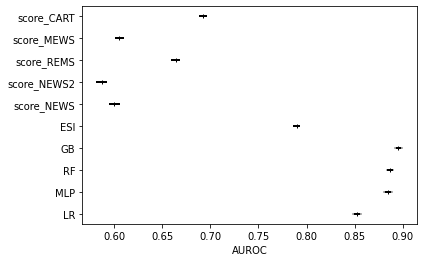

In [38]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )

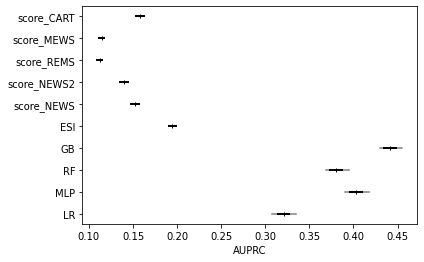

In [39]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC" )

In [40]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
18,triage_acuity,0.199948
0,age,0.090316
12,triage_heartrate,0.083431
15,triage_sbp,0.076034
14,triage_o2sat,0.071569
16,triage_dbp,0.067359
17,triage_pain,0.059165
11,triage_temperature,0.054345
13,triage_resprate,0.046938
4,n_ed_365d,0.018147
